## **Overview**
This project aims to predict the average price of golden delicious apples 

## **Import Dependencies**

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

## **Load Data**

In [40]:
train = pd.read_csv('data/df - train_set.csv')
train = train[train.Commodities == 'APPLE GOLDEN DELICIOUS']

## **Data Cleaning**


### **Data Overview**
Before studying the dataframe we need to remove the Commodities Column as it contains one item "APPLE GOLDEN DELICIOUS"


In [41]:
train.drop("Commodities",inplace=True,axis=1)


Obtained the first 5 rows to get an idea of the type of data we are dealing with.

In [43]:
train.head()


,Province,Container,Size_Grade,Weight_Kg,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
1,CAPE,M4183,1L,18.3,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
7,CAPE,JG110,2M,11.0,2020-04-14,50.0,50.0,16000.0,320,3520.0,0,4.55
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,2020-04-16,55.0,55.0,990.0,18,162.0,1506,6.11
40,CAPE,M4183,1S,18.3,2020-05-04,80.0,120.0,32020.0,388,7100.4,443,4.51
69,EASTERN CAPE,IA400,1S,400.0,2020-09-28,1800.0,1800.0,1800.0,1,400.0,2,4.50


We studied the structure of our data. We retrieved the dimension, the various column names, their respective counts and data types. The data consist of 1952 rows and 12 columns. The columns consist 8 numerical features, 3 categorical features and 1 date feature still in string format. The number of rows is the same as the number of values in each column so we can assume that the data does not contain any missing values.

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 1 to 64310
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Province          1952 non-null   object 
 1   Container         1952 non-null   object 
 2   Size_Grade        1952 non-null   object 
 3   Weight_Kg         1952 non-null   float64
 4   Date              1952 non-null   object 
 5   Low_Price         1952 non-null   float64
 6   High_Price        1952 non-null   float64
 7   Sales_Total       1952 non-null   float64
 8   Total_Qty_Sold    1952 non-null   int64  
 9   Total_Kg_Sold     1952 non-null   float64
 10  Stock_On_Hand     1952 non-null   int64  
 11  avg_price_per_kg  1952 non-null   float64
dtypes: float64(6), int64(2), object(4)
memory usage: 198.2+ KB


We counted the number of unique values in each column.The data consists of 7 different provinces, 11 container types and 10 different size_grade. Furthermore we discovered that the data was collected over 147 different days

In [15]:
train.nunique()


Province               7
Container             11
Size_Grade            10
Weight_Kg              9
Date                 147
Low_Price             94
High_Price            88
Sales_Total         1324
Total_Qty_Sold       505
Total_Kg_Sold        850
Stock_On_Hand        735
avg_price_per_kg     601
dtype: int64

## **Exploratory Data Analysis**

### **Numerical Variables**

We obtained the summary statistics of all the numerical columns. From the table below, it is evident that all our independent numerical features are extremely skewed to the right. Their means are significantly higher than their mean. This indicates that more of the observations are to the left of the mean and that there are a couple of values to the extreme right. The response (avg_price_per_kg)

In [8]:
train.describe()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
count,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000
mean,40.460912,174.307377,215.648053,20053.533811,174.510758,2960.176332,408.393955,6.778893
std,99.655169,373.553578,433.546159,39005.069445,308.810797,6097.416527,724.450582,2.248744
min,3.000000,2.000000,5.000000,5.000000,1.000000,3.000000,0.000000,0.250000
25%,9.000000,50.000000,60.000000,1325.000000,12.000000,219.600000,9.000000,5.460000
50%,12.000000,80.000000,108.000000,5495.000000,64.000000,853.500000,126.500000,6.670000
75%,18.300000,127.250000,160.000000,21082.500000,200.000000,3093.525000,468.000000,8.280000
max,400.000000,2300.000000,3300.000000,369464.000000,4237.000000,74000.000000,6400.000000,21.240000


Furthermore we plotted the histograms of all the numerical variables, and they confirmed the above findings.

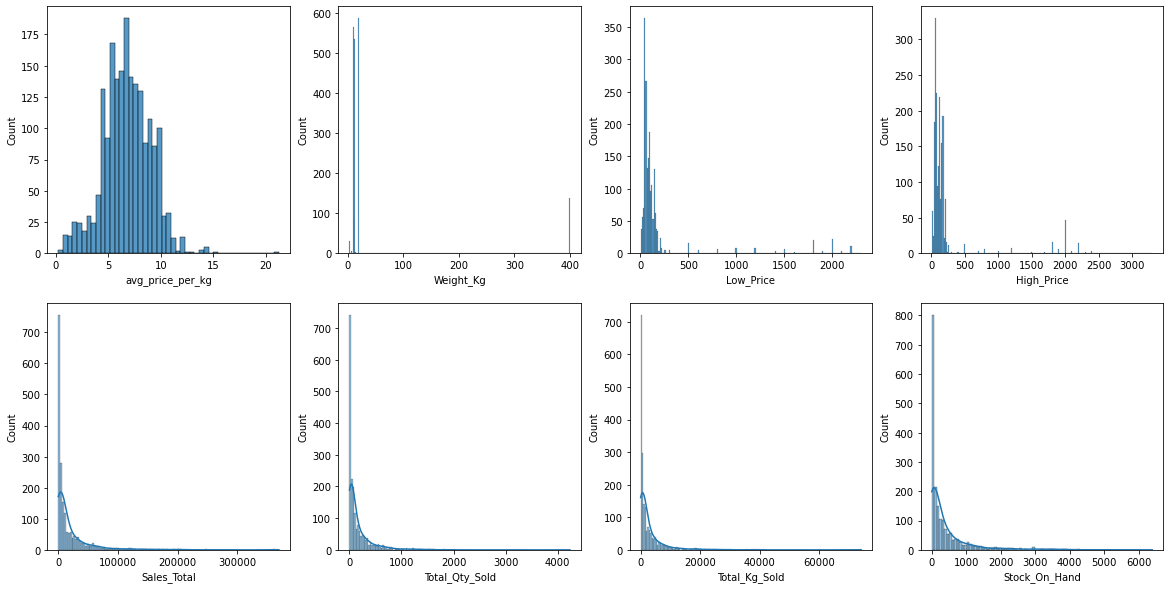

In [10]:

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

sns.histplot(train.avg_price_per_kg,ax=axs[0,0])
sns.histplot(train.Weight_Kg,ax=axs[0,1])
sns.histplot(train.Low_Price,ax=axs[0,2])
sns.histplot(train.High_Price,ax=axs[0,3])
sns.histplot(train.Sales_Total,kde=True,ax=axs[1,0])
sns.histplot(train.Total_Qty_Sold,kde=True,ax=axs[1,1])
sns.histplot(train.Total_Kg_Sold,kde=True,ax=axs[1,2])
sns.histplot(train.Stock_On_Hand,kde=True,ax=axs[1,3])

plt.show()


Now let us evaluate whether time has an effect on our avg_price_per_kg

In [17]:
train['Date']=pd.to_datetime(train['Date']) #converting to datetime
    

In [22]:
df = train.groupby(train['Date'])['avg_price_per_kg'].mean() #getting the average_per_kg_per_date


Text(0.5, 0, 'Date')

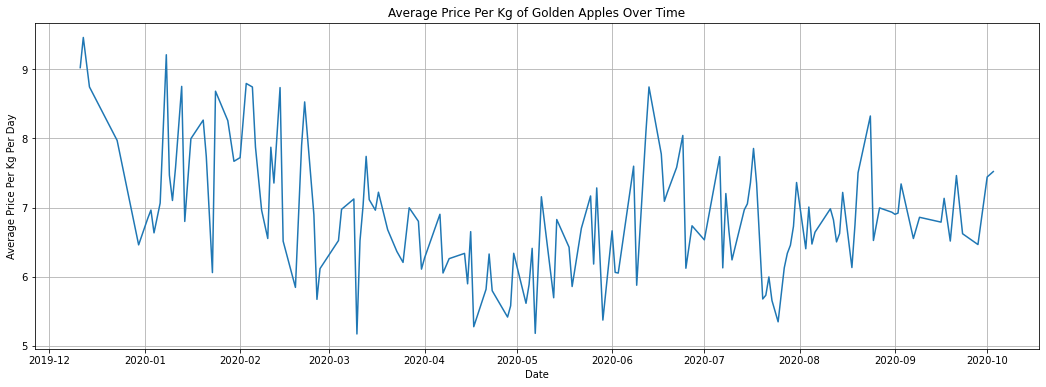

In [36]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df)
ax.grid(True)
ax.set_title('Average Price Per Kg of Golden Apples Over Time')
ax.set_ylabel('Average Price Per Kg Per Day')
ax.set_xlabel('Date')


C:\Users\nknhl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nknhl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nknhl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nknhl\anacond

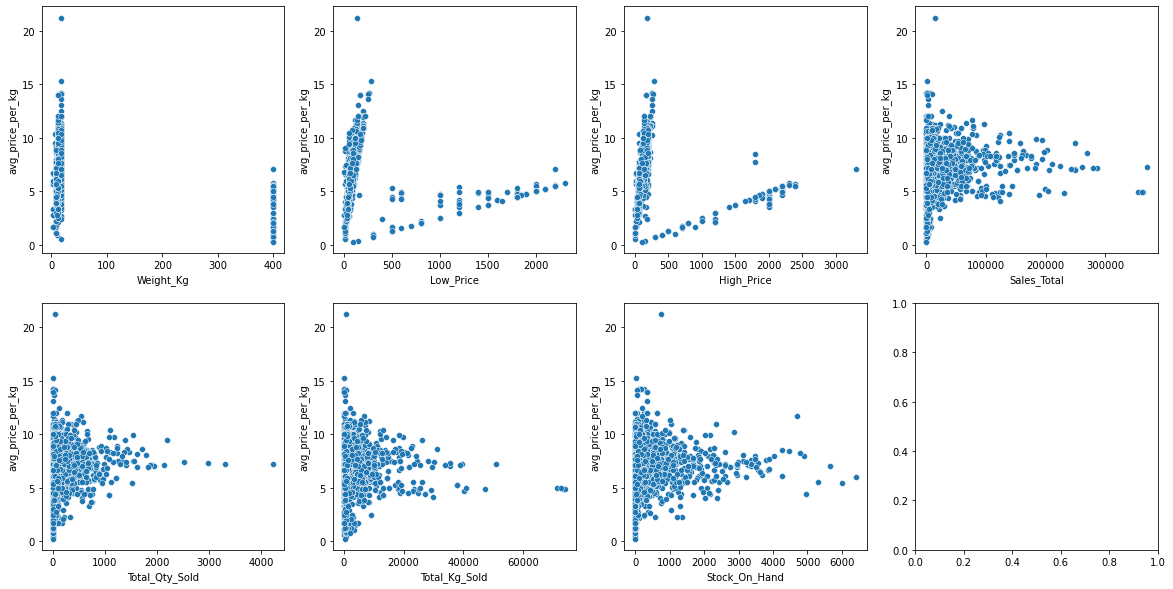

In [48]:

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

sns.scatterplot(train.Weight_Kg,train.avg_price_per_kg,ax=axs[0,0])
sns.scatterplot(train.Low_Price,train.avg_price_per_kg,ax=axs[0,1])
sns.scatterplot(train.High_Price,train.avg_price_per_kg, ax=axs[0,2])
sns.scatterplot(train.Sales_Total,train.avg_price_per_kg,ax=axs[0,3])
sns.scatterplot(train.Total_Qty_Sold,train.avg_price_per_kg,ax=axs[1,0])
sns.scatterplot(train.Total_Kg_Sold,train.avg_price_per_kg,ax=axs[1,1])
sns.scatterplot(train.Stock_On_Hand,train.avg_price_per_kg,ax=axs[1,2])

plt.show()

In [53]:
num_fil=['avg_price_per_kg','Weight_Kg','Low_Price','High_Price','Sales_Total', 'Total_Qty_Sold','Total_Kg_Sold','Stock_On_Hand']
num_df=train[num_fil]

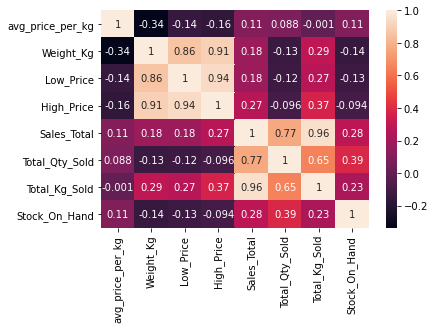

In [57]:
heat_map = sns.heatmap(num_df.corr(),annot=True)


## **Categorical Variables**

<AxesSubplot:xlabel='count', ylabel='Province'>

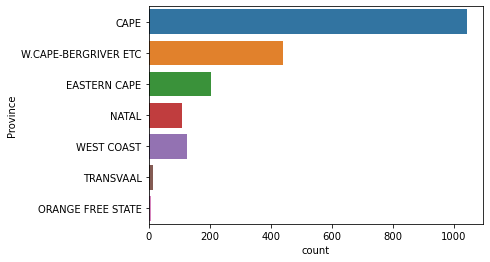

In [71]:
sns.countplot(y='Province',data=train)

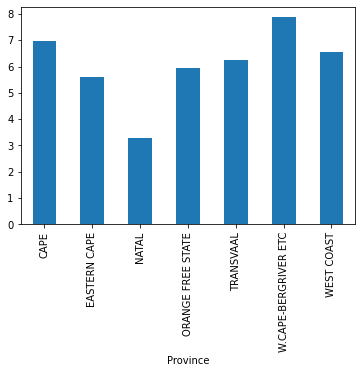

In [80]:
train.groupby(train['Province'])['avg_price_per_kg'].mean().plot(kind='bar')

plt.show()


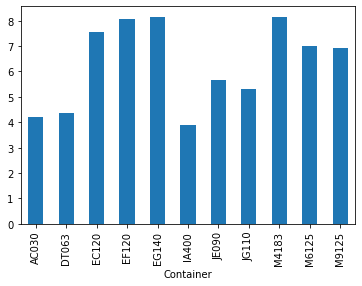

In [81]:
train.groupby(train['Container'])['avg_price_per_kg'].mean().plot(kind='bar')

plt.show()

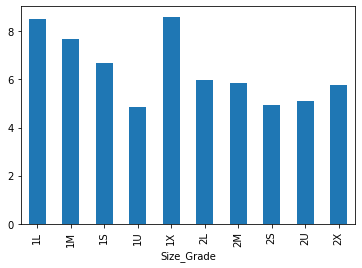

In [82]:
train.groupby(train['Size_Grade'])['avg_price_per_kg'].mean().plot(kind='bar')

plt.show()